#**Part 1**

Consider a location-scale-t-norm-halfnorm-discrete-uniform specification as described in the lecture slides.

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \tau^2, \nu)}{\quad\quad\quad p(x|\mu,\tau^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \tau^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\tau^2}\right)^{-(\nu+1) / 2}}$$


$$\scriptsize {p(\mu | \mu_0, \sigma_0^2) = \sqrt{\frac{1}{2\pi \sigma_0^2}} e^{-\frac{\left(\mu-\mu_0\right)^2}{2\sigma_0^2}}}\quad {p(\tau^2 | \sigma_1^2) = \frac{\sqrt{2}}{\sigma_1 \sqrt{\pi}} \exp \left(-\frac{(\tau^2)^2}{2 \sigma_1^2}\right)} \quad p(\nu=i) = \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}
$$

$$\tiny \text{normal} \quad\quad\quad\quad\quad\quad\quad \text{half-normal} \quad\quad\quad\quad\quad\quad\quad\quad \text{discrete uniform}$$

INFO:pymc.sampling.mcmc:Sequential sampling (3 chains in 1 job)
INFO:pymc.sampling.mcmc:CompoundStep
INFO:pymc.sampling.mcmc:>NUTS: [mu, tau2]
INFO:pymc.sampling.mcmc:>Metropolis: [v]


INFO:pymc.sampling.mcmc:Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 23 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


    mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v  59.99  23.37      17.0       98.0       7.27     5.29     11.39     81.05   

   r_hat  
v   1.18  


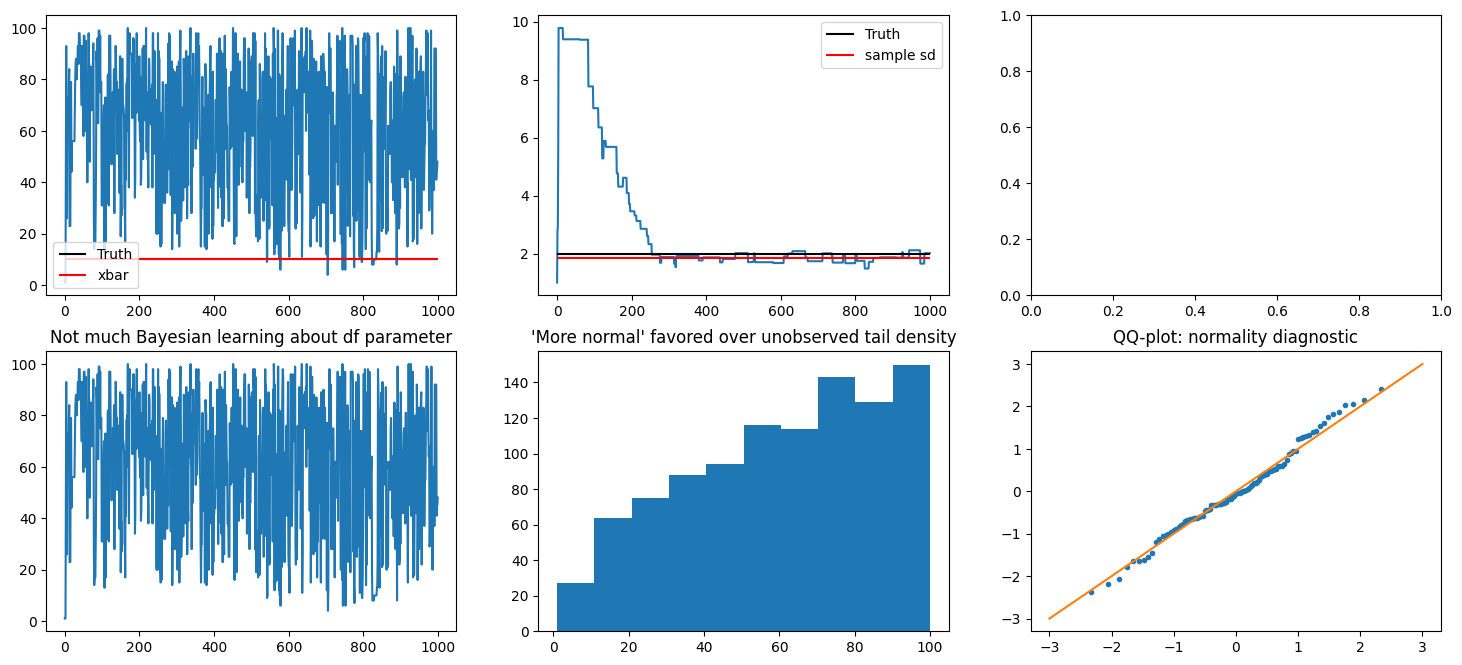

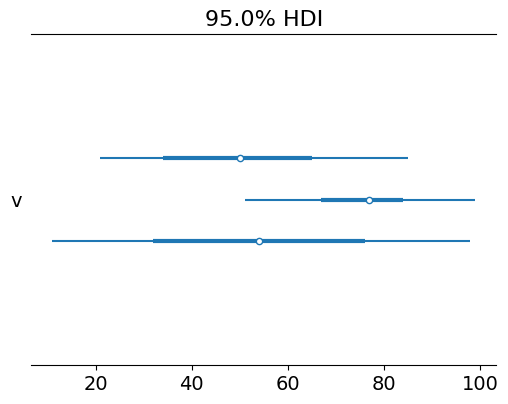

In [ ]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import arviz as az

#Generate the model
mu_0 = 0
sigma_0 =10
loc_prior = stats.norm(loc=mu_0, scale=sigma_0) # mean=mu_0 / std=sigma_0
scale_prior = stats.halfnorm(scale=5) # std=1
df_prior = stats.randint(low=1, high=101) # df ~ Unif{1, 2, ..., 100}

n,loc_true,scale_true,df_true = 100,10,2,15 # True values data will be from... IRL, we don't know these values
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n) # Data from location-scale-t distribution

loglikelihood = lambda loc,scale,df: stats.t(loc=loc, scale=scale, df=df).logpdf(x).sum()
logjoint_eval_at_x = lambda loc,scale,df: (loglikelihood(loc,scale,df)+\
                                           loc_prior.logpdf(loc)+scale_prior.logpdf(scale)+df_prior.logpmf(df))

loc_perturbation_MH_proposal_tuning_parameter = 0.1
loc_perturbation_MH_proposal_distribution = stats.norm(scale=loc_perturbation_MH_proposal_tuning_parameter)

scale_fixed_iid_MH_proposal_distribution = scale_prior # tuning parameters taken to be prior hyperparameters
df_fixed_iid_MH_proposal_distribution = df_prior # tuning parameters taken to be prior hyperparameters

T=1000
loc_MH_samples,scale_MH_samples,df_MH_samples = np.ones(T),np.ones(T),np.ones(T)

for t in range(1,T):
    # loc
    current_loc = loc_MH_samples[t-1]; proposed_loc = current_loc + loc_perturbation_MH_proposal_distribution.rvs()
    log_acceptance_probability = logjoint_eval_at_x(proposed_loc, scale_MH_samples[t-1], df_MH_samples[t-1])-\
                                 logjoint_eval_at_x(current_loc, scale_MH_samples[t-1], df_MH_samples[t-1])
    loc_MH_samples[t] = [current_loc,proposed_loc][int(stats.uniform().rvs() < np.exp(log_acceptance_probability))]

    # scale
    current_scale = scale_MH_samples[t-1]; proposed_scale = scale_fixed_iid_MH_proposal_distribution.rvs()
    logtarget_ratio = logjoint_eval_at_x(loc_MH_samples[t], proposed_scale, df_MH_samples[t-1])-\
                      logjoint_eval_at_x(loc_MH_samples[t], current_scale, df_MH_samples[t-1])
    logMH_proposal_correction_factor = scale_fixed_iid_MH_proposal_distribution.logpdf(current_scale)-\
                                       scale_fixed_iid_MH_proposal_distribution.logpdf(proposed_scale)
    acceptance_probability = np.exp(logtarget_ratio+logMH_proposal_correction_factor)
    scale_MH_samples[t] = [current_scale,proposed_scale][int(stats.uniform().rvs() < acceptance_probability)]

    # df
    current_df = df_MH_samples[t-1]; proposed_df = df_fixed_iid_MH_proposal_distribution.rvs()
    log_acceptance_probability = logjoint_eval_at_x(loc_MH_samples[t], scale_MH_samples[t], proposed_df)-\
                                 logjoint_eval_at_x(loc_MH_samples[t], scale_MH_samples[t], current_df)
    df_MH_samples[t] = [current_df,proposed_df][int(stats.uniform().rvs() < np.exp(log_acceptance_probability))]



# PyMC Model Specification
model = pm.Model();
with model:
    mu = pm.Normal('mu', mu=0, sigma=10)
    tau2 = pm.HalfNormal('tau2', sigma=5)
    v = pm.DiscreteUniform('v', lower=1, upper=100)
    likelihood = pm.StudentT('likelihood', nu=v, mu=mu, sigma=tau2**0.5, observed=x)

with model:
  trace = pm.sample(5000, chains=3, tune=1000, random_seed= [1007086172, 1007086173, 1007086175],
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

summary = az.summary(trace, var_names = 'v', round_to=2, hdi_prob=0.95)
print(summary)

fig,ax = plt.subplots(2,3,figsize=(18,8))
ax[0,0].plot(df_MH_samples); ax[0,0].hlines(loc_true,xmin=0,xmax=T,label='Truth',color='black'); ax[0,0].hlines(x.mean(),xmin=0,xmax=T,label='xbar',color='red'); ax[0,0].legend(); ax[0,1].plot(scale_MH_samples); ax[0,1].hlines(scale_true,xmin=0,xmax=T,label='Truth',color='black'); ax[0,1].hlines(x.std(),xmin=0,xmax=T,label='sample sd',color='red'); ax[0,1].legend(); ax[1,0].plot(df_MH_samples); ax[1,1].hist(df_MH_samples); ax[1,0].set_title("Not much Bayesian learning about df parameter");  ax[1,1].set_title("'More normal' favored over unobserved tail density"); ax[1,2].plot(stats.norm.ppf(np.linspace(0,1,n+2))[1:-1],sorted((x-x.mean())/x.std()),'.'); ax[1,2].plot([-3,3],[-3,3]); ax[1,2].set_title("QQ-plot: normality diagnostic");

#Bayesian Credible Interval for df parameter (v)
az.plot_forest(trace, var_names = 'v', hdi_prob=0.95)
plt.show()

Based on the graphs above, as more samples of the posterior are conducted, in particular around the 200 marks, the posterior df parameter stabilizes closer to the true df parameter. The histogram provided also shows a slightly left skewed plot, with smoothness and no significant gaps appearing as more samples are drawn, which would indicate that the more the posterior is sampled, the sample sizes bemore more sufficient at capturing the underlying distribution.


#**Part 2**

# Posterior analysis for Part 1
(a) **effective sample sizes**:
$n_{\text{eff}} = \frac{n}{\sum_{t=-\infty}^\infty\rho_t} = \frac{n}{1+2\sum_{t=1}^\infty\rho_t}$

for order $t$ autocorrelations $\rho_t$

Based on the table below, the ess_tail provides the effective sample size for parameter v for 5% and 95% quantiles, and this value is 180.0.

$n_{eff} = 180$

In [ ]:
trace.posterior['v'].values.flatten().shape[-1]
az.summary(trace, var_names = 'v')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,75.526,25.925,25.0,100.0,13.532,11.27,4.0,261.0,1.5


(b) **chain convergence measures**: traceplot for convergence checks

HMC Split-Rhats {'v': 1.503}


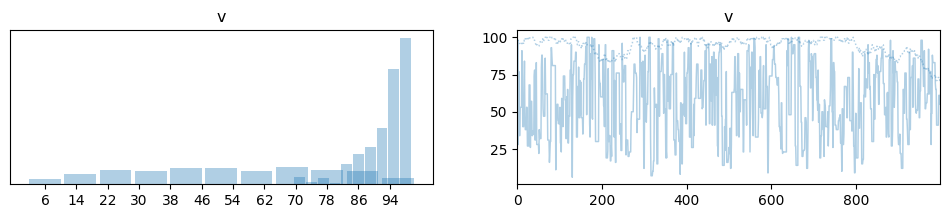

In [ ]:
az.plot_trace(trace, var_names = 'v')
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(trace).items() if k == 'v'})

(c) **divergences**: $p(\theta_0,v_0|x) \not = p(\theta_t,v_t|x) \approx 0$

Based on the model specification above, there appears to be no divergences.


(d) **Metropolis-Hastings acceptance rates**




In [ ]:
trace.sample_stats.acceptance_rate.values.flatten()

array([0.9015689 , 1.        , 1.        , ..., 0.88299889, 0.91712655,
       0.9623016 ])

Text(0.5, 1.0, 'Acceptance Rates for df Parameter')

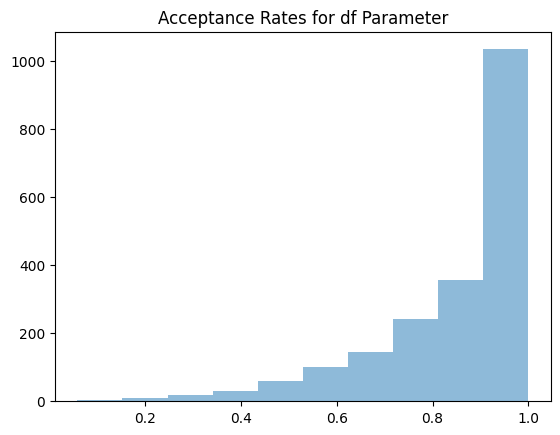

In [ ]:
plt.hist(trace.sample_stats.acceptance_rate.values.flatten(), alpha=0.5)
plt.title('Acceptance Rates for df Parameter')

(e) **other**

#Eight Schools Example


In [ ]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

pm.model_to_graphviz(Centered_eight)

# This posterior distribution implied by this specification can be sampled from
# using HMC where the necessary auxiliary variables are added "under the hood"

SEED = [20100420, 20134234] # random seeds for each of two run HMC chains

with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

# We can get some more information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood":True})



INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [mu, tau, theta]


INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 34 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [mu, tau, theta_t]


INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


(a) **effective sample sizes**:
$n_{\text{eff}} = \frac{n}{\sum_{t=-\infty}^\infty\rho_t} = \frac{n}{1+2\sum_{t=1}^\infty\rho_t}$

for order $t$ autocorrelations $\rho_t$

In [ ]:
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])


Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,623.0,11120.0
tau,129.0,5121.0
theta[0],538.0,10859.0
theta[1],978.0,11965.0
theta[2],1575.0,11071.0
theta[3],965.0,12523.0
theta[4],1673.0,11294.0
theta[5],1769.0,10616.0
theta[6],415.0,11073.0
theta[7],1248.0,11415.0


(b) **chain convergence measures**

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

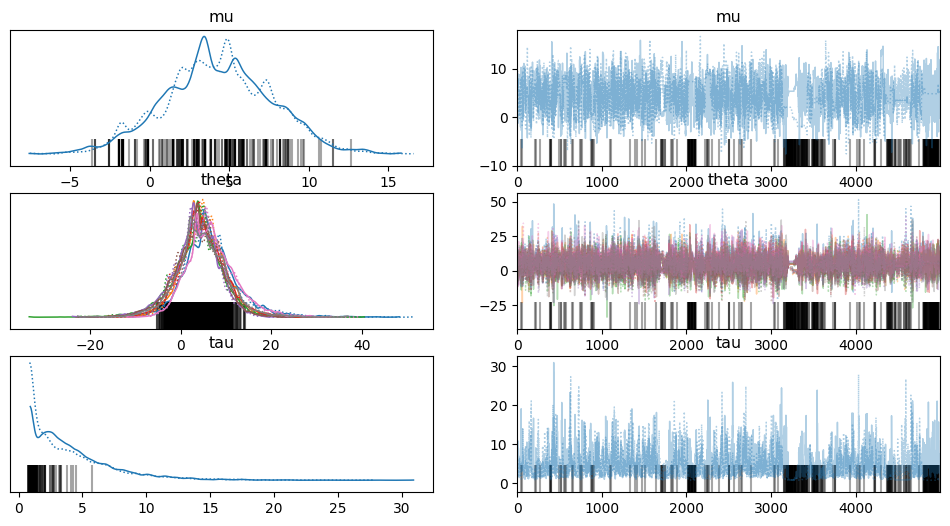

In [ ]:
#For centred model
az.plot_trace(fit_C)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta_t'}>,
        <Axes: title={'center': 'theta_t'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

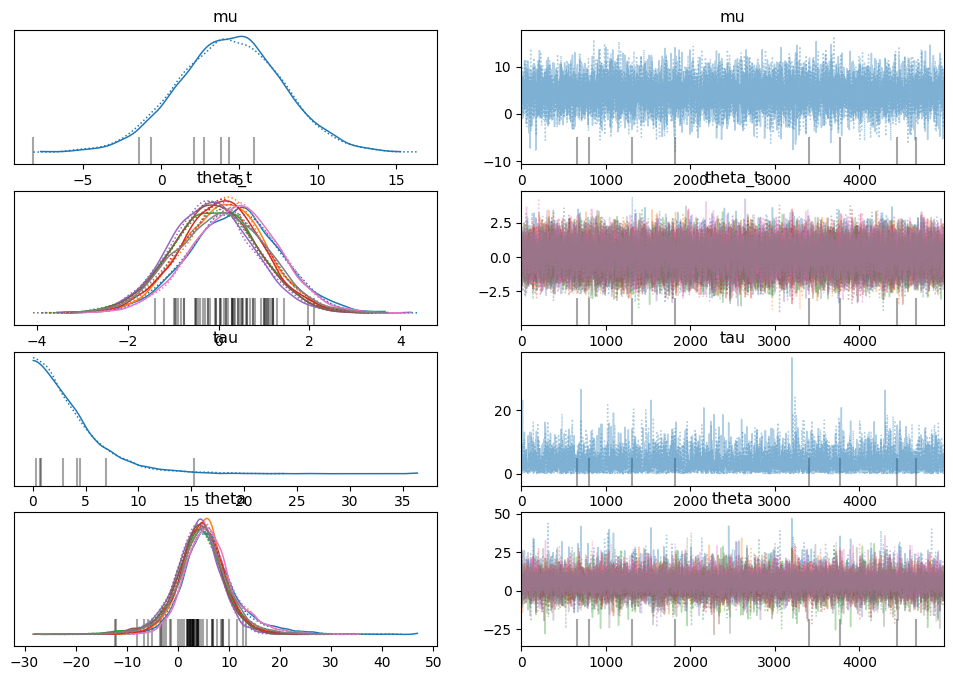

In [ ]:
#For non-centred model
az.plot_trace(fit_NC)

(c) **divergences**

From the development of the model using PyMC, the firts "centered" model lead to many divergences, due to the specification inducing high curate in the energy. An alternative parametrization to the model is provided and the divergences are reduced significantly.

(d) **Metropolis-Hastings Acceptance Rates**

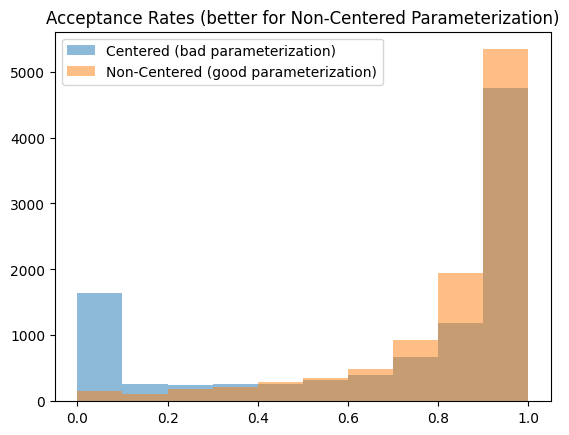

In [ ]:
import matplotlib.pyplot as plt
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();


The "uncentered" parameterization performs better than the "centered" parameterization because the "centered" parameterization typically exhibits higher curvature in the energy function due to the centering transformation applied to the parameters.This increased curvature can lead to slower exploration of the posterior distribution and higher autocorrelation in the samples.

Furthermore, high autocorrelation and low Metropolis-Hastings acceptance rates mean it's computationally expensive to make proposals, and the proposals can't be moved far away and are only being accepted when they're still "close" to the previous values and so the HMC algorithm is failing and inefficient. From the acceptance rates histogram above, the "centered" parameterization tends to have lower acceptance rates than the uncentered parameterization.

In summary, the "uncentered" parameterization performs better because it reduces the curvature of the energy function, allowing for more efficient exploration of the posterior distribution by the HMC algorithm.

#Diagnostic Plots

Diagnostic plots assess energy proposals vs emperical energy distribution of the generated HMC samples.
Based on the plots below, the first diagnostic plot is for the centered parameterization, and shows a clear excessive curvature to the marginal energy.
The second diagnostic plot is for the uncentered parametrization, and shows less curvature for the the marginal energy, whcih supports the claim that the uncentered parametrization performs better.
When there is less curvature to the energy function, moire efficient exploration of the posterior distribution by the HMC algorithm is facilitated, so the algorithm's perfomance is better. This supports the previous claim of the uncentered parametrization having better performance.


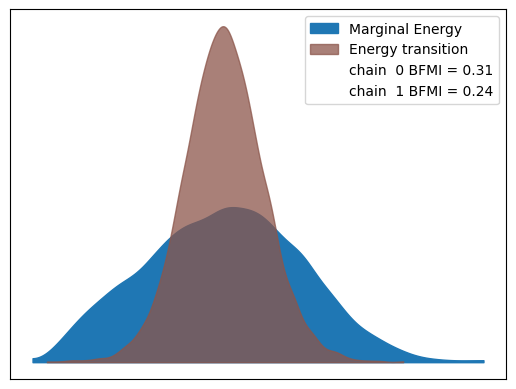

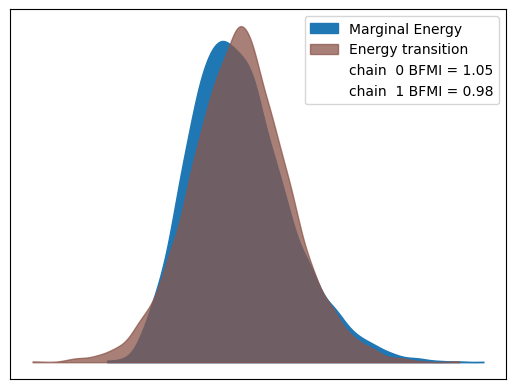

In [ ]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);